# Análise Comparativa

#### **Importando Bibliotecas**

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, ShuffleSplit, KFold, cross_validate

#### **Leitura dos Dados**

In [2]:
df= pd.read_csv("../data/raw/wines_SPA.csv")
df.head()

,winery,wine,year,rating,num_reviews,country,region,price,type,body,acidity
0,Teso La Monja,Tinto,2013,4.9,58,Espana,Toro,995.00,Toro Red,5.0,3.0
1,Artadi,Vina El Pison,2018,4.9,31,Espana,Vino de Espana,313.50,Tempranillo,4.0,2.0
2,Vega Sicilia,Unico,2009,4.8,1793,Espana,Ribera del Duero,324.95,Ribera Del Duero Red,5.0,3.0
3,Vega Sicilia,Unico,1999,4.8,1705,Espana,Ribera del Duero,692.96,Ribera Del Duero Red,5.0,3.0
4,Vega Sicilia,Unico,1996,4.8,1309,Espana,Ribera del Duero,778.06,Ribera Del Duero Red,5.0,3.0


In [3]:
df_dict = pd.read_csv('../data/external/dictionary.csv')
df_dict

,variavel,descricao,tipo,subtipo
0,winery,Nome da vinícola,qualitativa,nominal
1,wine,Nome do vinho,qualitativa,nominal
2,year,Ano em que as uvas foram colhidas,quantitativa,discreta
3,rating,Avaliação média dada ao vinho pelos usuários [...,quantitativa,contínua
4,num_reviews,Número de usuários que avaliaram o vinho,quantitativa,discreta
5,country,País de origem [Espanha],inútil,inútil
6,region,Região do vinho,qualitativa,nominal
7,price,Preço em euros [€],quantitativa,contínua
8,type,Variedade de vinho,qualitativa,nominal
9,body,"Pontuação de corpo, definida como a riqueza e ...",qualitativa,ordinal


#### **Renomeando as colunas**

In [4]:
mapeamento_colunas = {
    'winery': 'vinícola',
    'wine': 'vinho',
    'year': 'ano',
    'rating': 'avaliação',
    'num_reviews': 'num_avaliações',
    'country': 'país',
    'region': 'região',
    'price': 'preço',
    'type': 'tipo',
    'body': 'corpo',
    'acidity': 'acidez'
}

In [5]:
def renomear_colunas(df, mapping):
    df.rename(columns=mapping, inplace=True)
    return df

In [6]:
df_dict['variavel'] = df_dict['variavel'].replace(mapeamento_colunas)
df = renomear_colunas(df, mapeamento_colunas)

## 1. Tratamento e Transformação de dados

#### **Verificando os Valores Faltantes e Dados Duplicados**

In [7]:
print(df.duplicated().sum())

5452


In [8]:
df = df.drop(df[df.duplicated()].index, axis=0)
df.reset_index()
print(f'Número de Duplicados: {df.duplicated().sum()}')

Número de Duplicados: 0


In [9]:
df['ano'] = df['ano'].replace('N.V.', np.nan)
df['ano'] = df['ano'].astype(pd.Int64Dtype())

In [10]:
print(f'Verificando valores faltantes : \n\n{df.isna().sum()}')

Verificando valores faltantes : 

vinícola            0
vinho               0
ano                72
avaliação           0
num_avaliações      0
país                0
região              0
preço               0
tipo              106
corpo             271
acidez            271
dtype: int64


#### **Verificando os Valores Discrepantes**

In [11]:
# Função para identificar outliers usando o IQR
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)  # Primeiro quartil
    Q3 = df[column].quantile(0.75)  # Terceiro quartil
    IQR = Q3 - Q1                     # Intervalo Interquartil
    
    lower_bound = Q1 - 1.5 * IQR      # Limite inferior
    upper_bound = Q3 + 1.5 * IQR      # Limite superior
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

In [12]:
# Detectando outliers apenas para colunas numéricas
outliers_summary = []

for col in df.select_dtypes(include=[np.number]).columns:  # Filtra apenas colunas numéricas
    outliers = detect_outliers_iqr(df, col)
    if not outliers.empty:
        outliers_summary.append({'Coluna': col, 'Quantidade de Outliers': len(outliers)})

outliers_df = pd.DataFrame(outliers_summary)

print(outliers_df)

           Coluna  Quantidade de Outliers
0             ano                     165
1       avaliação                       2
2  num_avaliações                     242
3           preço                     245
4           corpo                      34
5          acidez                     105


In [13]:
df['preço'] = np.log1p(df['preço'])

## 2. Pré-Processamento dos Dados

#### **Definição das Variáveis do Modelo de Previsão**

In [14]:
# Variável alvo
target_variable = 'preço'

# Variáveis inúteis
useless_variables = (
    df_dict
    .query("tipo == 'inútil'")
    .variavel
    .to_list()
)

# Variáveis nominais
nominal_variables = (
    df_dict
    .query("subtipo == 'nominal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis ordinais
ordinal_variables = (
    df_dict
    .query("subtipo == 'ordinal' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis contínuas
continuous_variables = (
    df_dict
    .query("subtipo == 'contínua' and variavel != @target_variable")
    .variavel
    .to_list()
)

# Variáveis discretas
discrete_variables = (
    df_dict
    .query("subtipo == 'discreta' and variavel != @target_variable")
    .variavel
    .to_list()
)

In [15]:
X = df.drop(columns=[target_variable] + useless_variables)
y = df[target_variable]

In [16]:
# Exibindo as categorias de variáveis
print("Nominal Variables:", nominal_variables)
print("Ordinal Variables:", ordinal_variables)
print("Continuous Variables:", continuous_variables)
print("Discrete Variables:", discrete_variables)

Nominal Variables: ['vinícola', 'vinho', 'região', 'tipo']
Ordinal Variables: ['corpo', 'acidez']
Continuous Variables: ['avaliação']
Discrete Variables: ['ano', 'num_avaliações']


#### **Pré-processamento das Variáveis: Imputação e Codificação**

In [17]:
# Nominal variables: imputação de valores faltantes e codificação one-hot
nominal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="most_frequent")),  # Preenchimento com o valor mais frequente
    ("encoding", OneHotEncoder(sparse_output=False, handle_unknown="infrequent_if_exist"))  # Codificação One-Hot
])

# Ordinal variables: imputação de valores faltantes e codificação ordinal
ordinal_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="median")),  # Preenchimento com a mediana
    ("encoding", OrdinalEncoder())  # Codificação ordinal
])

# Continuous variables: imputação de valores faltantes e normalização
continuous_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="mean")),  # Preenchimento com a média
    ("normalization", StandardScaler())  # Normalização
])

# Discrete variables: imputação de valores faltantes e normalização
discrete_preprocessor = Pipeline(steps=[
    ("missing", SimpleImputer(strategy="median")),  # Preenchimento baseado em K vizinhos mais próximos
    ("normalization", StandardScaler())  # Normalização
])

In [18]:
# Criação do ColumnTransformer para processar cada tipo de variável
preprocessor = ColumnTransformer([
    ("nominal", nominal_preprocessor, nominal_variables),   
    ("ordinal", ordinal_preprocessor, ordinal_variables),   
    ("continuous", continuous_preprocessor, continuous_variables),  
    ("discrete", discrete_preprocessor, discrete_variables), 
])

In [19]:
preprocessor

ColumnTransformer(transformers=[('nominal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('encoding',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['vinícola', 'vinho', 'região', 'tipo']),
                                ('ordinal',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('encoding',
                                                  OrdinalEncoder())]),
                                 ['corpo', 'acidez']),
                                ('continuous',
                                 Pipeline(steps=[('missing', SimpleImputer()),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['avaliação']),
                                ('discrete',
                                 Pipeline(steps=[('missing',
                                                  SimpleImputer(strategy='median')),
                                                 ('normalization',
                                                  StandardScaler())]),
                                 ['ano', 'num_avaliações'])])

## 3. Avaliação e Comparação de Modelos

#### **Validação Cruzada e Métricas de Desempenho**

In [20]:
modelos = [DummyRegressor(strategy="mean"), LinearRegression(), SVR(), RandomForestRegressor(n_estimators=100, random_state=42)]

In [21]:
metricas = [
    'neg_mean_absolute_error',
    'neg_mean_squared_error',
    'neg_mean_absolute_percentage_error',
    'r2',
]

monte_carlo = ShuffleSplit(n_splits=10, test_size=.2, random_state=42)

In [22]:
results_total = None
for modelo in modelos:
    model_name = modelo.__class__.__name__
    print(f"rodando para o modelo: {model_name}")
    approach = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('modelo', modelo),
    ])

    scores = cross_validate(
        approach, X, y,
        scoring=metricas, 
        cv=monte_carlo
    )
    results_model = pd.DataFrame(scores)
    results_model['Modelo'] = model_name
    if results_total is None:
        results_total = results_model
    else:
        results_total = pd.concat([results_total, results_model])

rodando para o modelo: DummyRegressor
rodando para o modelo: LinearRegression
rodando para o modelo: SVR
rodando para o modelo: RandomForestRegressor


In [23]:
# Renomear colunas
results_total = results_total.rename(
    columns={
        "fit_time": "Tempo de Treinamento",
        "score_time": "Tempo de Avaliação",
        "test_neg_mean_absolute_error": "Erro Absoluto Médio (Negativo)",
        "test_neg_mean_squared_error": "Erro Quadrático Médio (Negativo)",
        "test_neg_mean_absolute_percentage_error": "Erro Percentual Médio (Negativo)",
        "test_r2": "Coeficiente de Determinação (R²)",
        "Modelo": "Modelo"
    }
)

In [38]:
resultado_agregado = results_total.groupby('Modelo').agg(['mean', 'std']).T
resultado_agregado

Modelo                                 DummyRegressor  LinearRegression  \
Tempo de Treinamento             mean        0.041647      1.208843e+00   
                                 std         0.008616      3.235178e-01   
Tempo de Avaliação               mean        0.017281      2.308359e-02   
                                 std         0.006272      8.830463e-03   
Erro Absoluto Médio (Negativo)   mean       -0.792764     -9.324610e+10   
                                 std         0.027047      8.202604e+10   
Erro Quadrático Médio (Negativo) mean       -1.054131     -1.062371e+23   
                                 std         0.077255      1.056937e+23   
Erro Percentual Médio (Negativo) mean       -0.193789     -2.663961e+10   
                                 std         0.008106      2.326120e+10   
Coeficiente de Determinação (R²) mean       -0.001687     -1.024013e+23   
                                 std         0.002000      1.059492e+23   

Modelo                                 RandomForestRegressor       SVR  
Tempo de Treinamento             mean               4.454626  1.717218  
                                 std                0.153546  0.135554  
Tempo de Avaliação               mean               0.023815  0.579123  
                                 std                0.007996  0.055546  
Erro Absoluto Médio (Negativo)   mean              -0.374220 -0.336210  
                                 std                0.013652  0.010954  
Erro Quadrático Médio (Negativo) mean              -0.258897 -0.213778  
                                 std                0.021582  0.017288  
Erro Percentual Médio (Negativo) mean              -0.091684 -0.082441  
                                 std                0.003643  0.003075  
Coeficiente de Determinação (R²) mean               0.753764  0.796460  
                                 std                0.014106  0.014804

In [26]:
#cor graficos
cor_media = "#D81B60"
cor_desvio = "#6A0DAD"

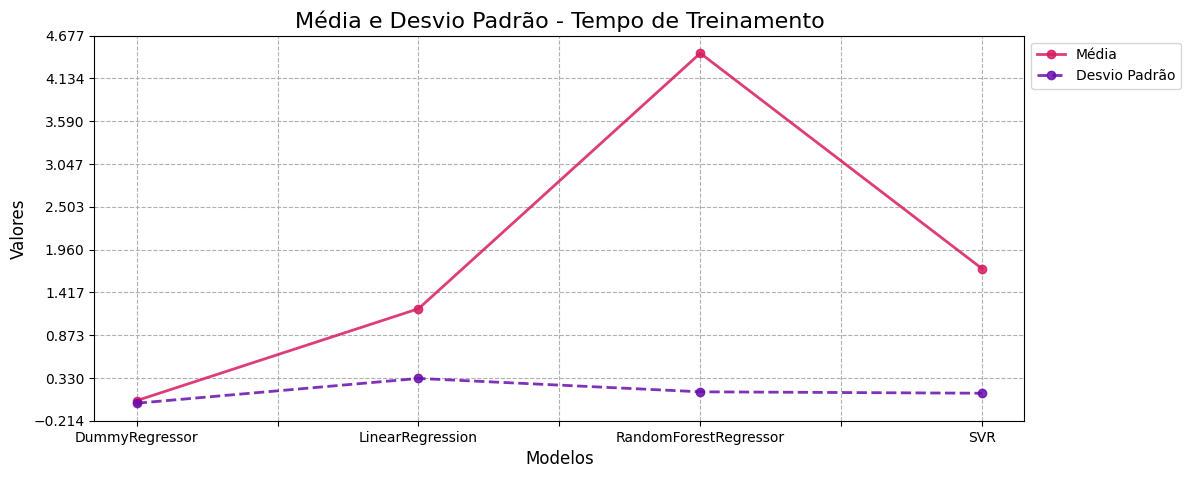

In [27]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Tempo de Treinamento']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Tempo de Treinamento']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Tempo de Treinamento", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média**:

    * **DummyRegressor:** Teve o menor tempo médio (0.0416s), refletindo sua simplicidade.
    * **LinearRegression:** Um tempo médio razoável (1.2088s), eficiente para um modelo linear.
    * **RandomForestRegressor:** Maior tempo de treinamento (4.4546s), devido ao uso de múltiplas árvores de decisão.
    * **SVR:** Um tempo médio moderado (1.7172s), inferior ao **RandomForest**, mas superior aos modelos lineares

* **Desvio Padrão:**
    * **DummyRegressor:** Variabilidade relativamente baixa (0.0086s), confirmando sua consistência.
    * **LinearRegression:** Baixa variabilidade (0.3235s), mostrando estabilidade.
    * **RandomForestRegressor:** Variabilidade moderada (0.1535s), esperada para métodos baseados em árvores.
    * **SVR:** Variabilidade moderada (0.1355s), indicando consistência.

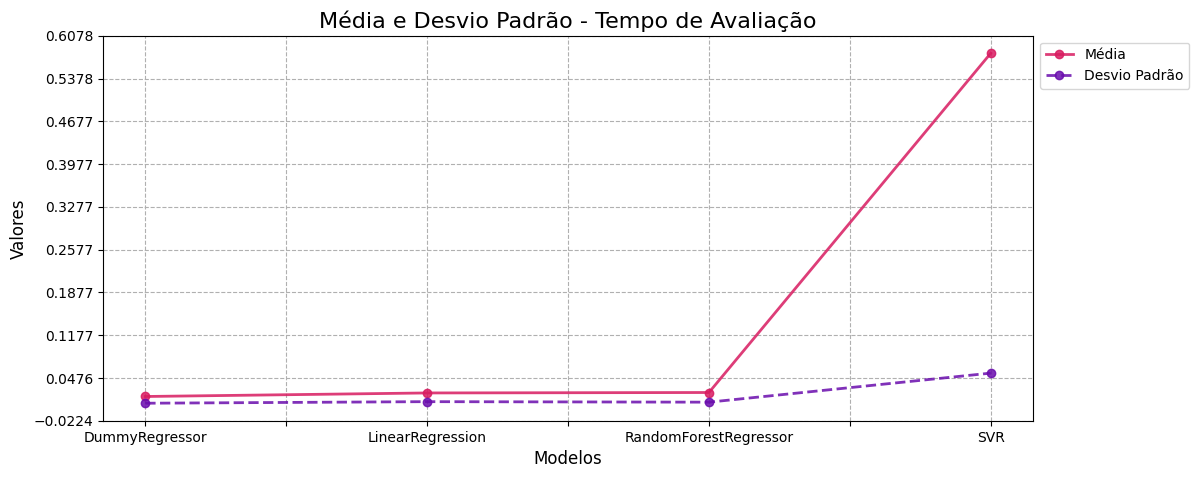

In [28]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Tempo de Avaliação']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Tempo de Avaliação']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Tempo de Avaliação", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média:**
    * **DummyRegressor:** Menor tempo médio (0.0173s), sendo o mais eficiente.
    * **LinearRegression:** Tempo médio competitivo (0.0231s), próximo ao **DummyRegressor**.
    * **RandomForestRegressor:** Tempo médio (0.0238s), destacando eficiência na avaliação.
    * **SVR:** Tempo médio mais elevado (0.5791s), devido à sua complexidade computacional.

* **Desvio Padrão:**
    * **DummyRegressor:** Baixa variabilidade (0.0062s), mantendo a eficiência.
    * **LinearRegression:** Variabilidade baixa (0.0088s), mostrando consistência.
    * **RandomForestRegressor:** Variabilidade baixa (0.0079s), evidenciando estabilidade.
    * **SVR:** Maior variabilidade (0.0555s), refletindo maior sensibilidade ao conjunto de dados.

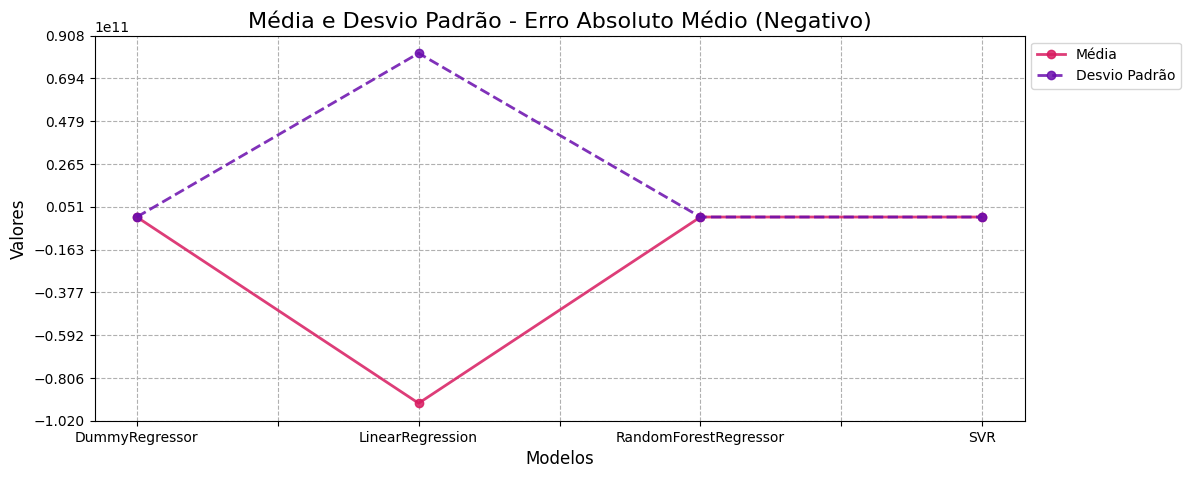

In [29]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Erro Absoluto Médio (Negativo)']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Erro Absoluto Médio (Negativo)']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Erro Absoluto Médio (Negativo)", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média:**
    * **DummyRegressor:** Desempenho básico esperado (-0.7928).
    * **LinearRegression:** Erro médio muito elevado (-9.3246e+10).
    * **RandomForestRegressor:** Menor erro médio (-0.3742), maior precisão.
    * **SVR:** Melhor desempenho (-0.3362), superando os demais modelos.

* **Desvio Padrão:**
    * **DummyRegressor:** Baixa variabilidade (0.0270), esperado para um modelo simples.
    * **LinearRegression:** Variabilidade extremamente alta (8.2026e+10), modelo instável.
    * **RandomForestRegressor:** Baixa variabilidade (0.0136), modelo consistente.
    * **SVR:** Baixa variabilidade (0.0109), modelo estável.

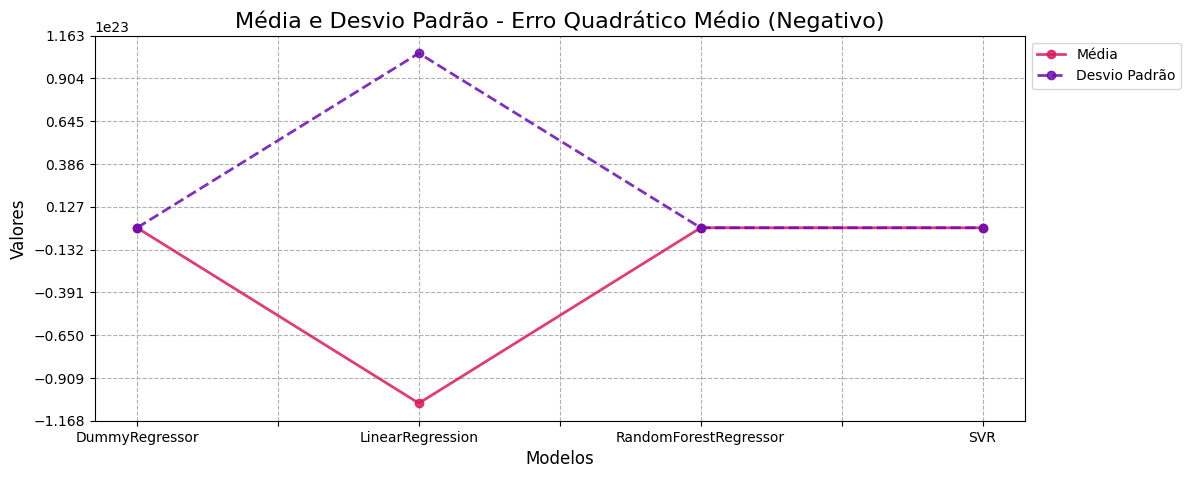

In [30]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Erro Quadrático Médio (Negativo)']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Erro Quadrático Médio (Negativo)']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Erro Quadrático Médio (Negativo)", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média:**
    * **DummyRegressor:** Erro elevado (-1.0541), servindo apenas como baseline.
    * **LinearRegression:** Desempenho inadequado (-1.0624e+23), modelo inviável.
    * **RandomForestRegressor:** Melhor erro médio (-0.2589), maior precisão.
    * **SVR:** Melhor erro médio (-0.2138), próximo ao **RandomForest**.

* **Desvio Padrão:**
    * **DummyRegressor:** Variabilidade moderada (0.0772), esperado para um baseline.
    * **LinearRegression:** Variabilidade altíssima (1.0569e+23), reforçando instabilidade.
    * **RandomForestRegressor:** Baixa variabilidade (0.0215), indicando estabilidade.
    * **SVR:** Baixa variabilidade (0.0172), confirmando consistência.

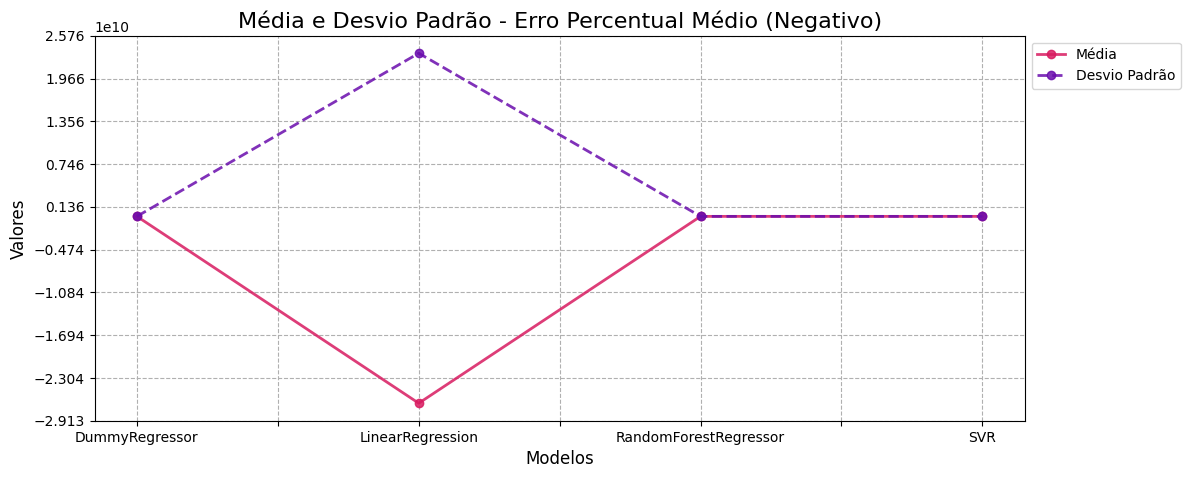

In [31]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Erro Percentual Médio (Negativo)']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Erro Percentual Médio (Negativo)']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Erro Percentual Médio (Negativo)", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média:**
    * **DummyRegressor:** Erro elevado (-0.1938), refletindo limitações do modelo.
    * **LinearRegression:** Erro percentual muito alto (-2.6639e+10).
    * **RandomForestRegressor:** Baixo erro percentual (-0.0917), destacando precisão.
    * **SVR:** Menor erro percentual médio (-0.0824), superando os demais.

* **Desvio Padrão**
    * **DummyRegressor:** Baixa variabilidade (0.0081), esperado para um modelo simples.
    * **LinearRegression:** Variabilidade extremamente alta (2.3261e+10), modelo sensivel.
    * **RandomForestRegressor:** Baixa variabilidade (0.0036), indicando estabilidade.
    * **SVR:** Baixa variabilidade (0.0030), mostrando consistência.


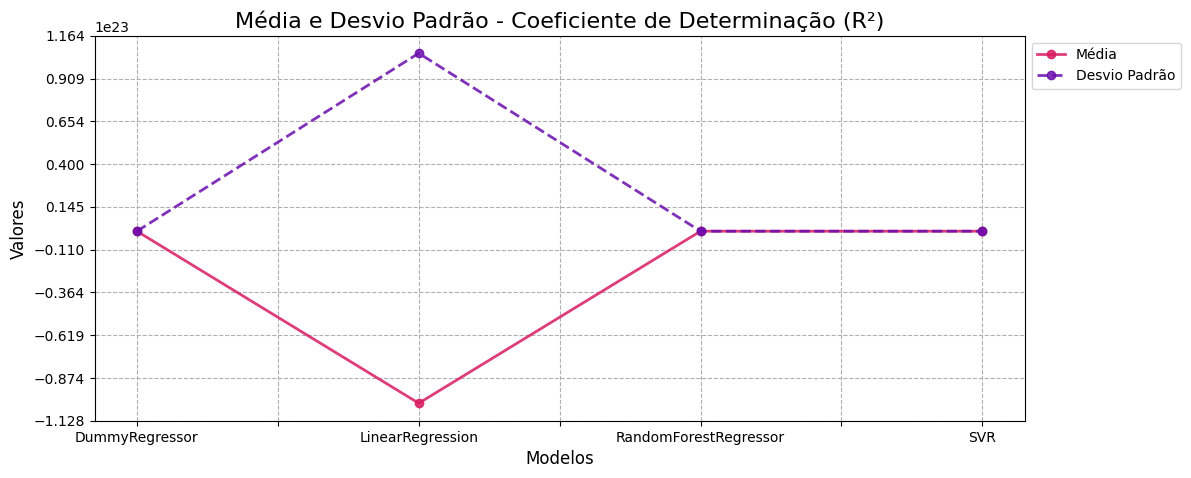

In [32]:
resultado_agregado_mean = resultado_agregado.xs('mean', level=1, axis=0).loc[['Coeficiente de Determinação (R²)']]
resultado_agregado_std = resultado_agregado.xs('std', level=1, axis=0).loc[['Coeficiente de Determinação (R²)']]

fig, ax = plt.subplots(figsize=(12, 5))

resultado_agregado_mean.T.plot(kind='line', marker='o', ax=ax, color=cor_media, alpha=0.85, label="Média", linewidth=2)
resultado_agregado_std.T.plot(kind='line', marker='o', ax=ax, color=cor_desvio, alpha=0.85, linestyle='--', label="Desvio Padrão", linewidth=2)

ax.set_title("Média e Desvio Padrão - Coeficiente de Determinação (R²)", fontsize=16)

ax.set_ylabel("Valores", fontsize=12)
ax.set_xlabel("Modelos", fontsize=12)

ax.legend(bbox_to_anchor=(1, 1), loc='upper left', labels=["Média", "Desvio Padrão"])

ax.grid(True, linestyle='--', alpha=1)

y_min, y_max = ax.get_ylim()
ax.set_yticks(np.linspace(y_min, y_max, num=10))

plt.show()

* **Média:**
    * **DummyRegressor:** R² próximo de 0 (-0.0017).
    * **LinearRegression:** Valor extremamente negativo (-1.0240e+23), inadequado para o problema.
    * **RandomForestRegressor:** Bom R² médio (0.7538), evidenciando excelente ajuste.
    * **SVR:** Melhor R² médio (0.7964), destacando-se como o modelo mais ajustado.

* **Desvio Padrão:**
    * **DummyRegressor:** Variabilidade muito baixa (0.0020), esperado para um baseline.
    * **LinearRegression:** Variabilidade extremamente alta (1.0595e+23), modelo inconsistente.
    * **RandomForestRegressor:** Variabilidade moderada (0.0141), modelo instavél.
    * **SVR:** Variabilidade baixa (0.0148), modelo consistente no desempenho.


#### **Predição do Modelo**

Divisão de treino e teste

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
# Aplicar o pré-processador aos dados de treino e teste
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

In [35]:
# Verificando o tamanho dos dados transformados
print("Shape of X_train_transformed:", X_train_transformed.shape)
print("Shape of X_test_transformed:", X_test_transformed.shape)

Shape of X_train_transformed: (1638, 1268)
Shape of X_test_transformed: (410, 1268)


In [36]:
# Dicionário para armazenar os modelos treinados
trained_models = {}
# Treinando os modelos com os dados transformados
for model in modelos:
    model_name = type(model).__name__
    model.fit(X_train_transformed, y_train)
    trained_models[model_name] = model

In [37]:
#df['preço'] = np.expm1(df['preço'])
# Fazendo predições
predictions = {}
for model_name, trained_model in trained_models.items():
    y_pred = trained_model.predict(X_test_transformed)
    predictions[model_name] = y_pred
    print(f"Predictions for {model_name}:")
    print(y_pred[:5])  # Exibindo as primeiras 5 predições

Predictions for DummyRegressor:
[4.17956997 4.17956997 4.17956997 4.17956997 4.17956997]
Predictions for LinearRegression:
[8.47527392e+09 4.05978417e+00 7.43184447e+00 4.62033057e+00
 4.05875373e+00]
Predictions for SVR:
[3.42159783 3.78997048 7.22446071 4.50556286 3.40738925]
Predictions for RandomForestRegressor:
[3.72484582 3.96430207 7.02458752 4.53668817 3.49149499]


1. **DummyRegressor**:

   * Saída: [4.17956997, 4.17956997, 4.17956997, 4.17956997, 4.17956997]
   * **Comportamento esperado**: O DummyRegressor é um modelo de baseline que gera predições constantes, normalmente usando a média ou a mediana dos valores da variável-alvo no conjunto de treino.

2. **LinearRegression**:

    * **Saída**: [8.47527392e+09, 4.05978417, 7.43184447, 4.62033057, 4.05875373]
    * **Problema**:O valor 4.73601734e+11 (um número extremamente alto) sugere explosão nos coeficientes da regressão.Isso pode ocorrer por problemas de escala nos dados, onde os recursos (features) possuem valores muito díspares.

3. **SVR (Support Vector Regressor)**:

    * **Saída**: [3.42159783, 3.78997048, 7.22446071, 4.50556286, 3.40738925]
    * **Comportamento razoável**: Os valores parecem mais próximos de um intervalo esperado. No entanto:
    Certifique-se de que o SVR foi treinado com dados escalados, pois este modelo é sensível à magnitude das features.

4. **RandomForestRegressor**:

    * **Saída**: [3.72484582, 3.96430207, 7.02458752, 4.53668817, 3.49149499]
    * **Comportamento razoável**: Assim como no SVR, os valores estão em um intervalo mais plausível.

## 4. Conclusão da Análise

###  **Resultados da Avaliação**

* **Tempo de Treinamento e Previsão:** O **DummyRegressor** destacou-se como o modelo mais rápido tanto para treinamento quanto para previsão, graças à sua simplicidade. O **SVR**, por outro lado, teve o tempo de avaliação mais elevado entre os modelos testados. Apesar disso, apresentou bom desempenho preditivo, mas foi superado pelo **RandomForestRegressor**.

* **Desempenho (Erro e R²):** O **RandomForestRegressor** apresentou os melhores resultados em termos de erro (MAE, MSE e MAPE) e capacidade de explicação da variância dos dados, com um R² superior a outros modelos. Ele demonstrou ser capaz de capturar padrões complexos nos dados, mantendo boas predições mesmo em cenários de variação moderada.

* **Conclusão Geral:** O **RandomForestRegressor** destacou-se como o modelo mais robusto, com excelente desempenho em todas as métricas de erro e explicação da variância dos dados. Embora o **SVR** também tenha apresentado bons resultados, especialmente em predições coerentes, o **RandomForestRegressor** demonstrou ser uma escolha mais equilibrada. O **DummyRegressor**, como esperado, serviu apenas como baseline inicial, enquanto o LinearRegression apresentou inconsistências.

| **Métrica**              | **Melhor Modelo**     | **Justificativa**                                                                 |
|--------------------------|-----------------------|-----------------------------------------------------------------------------------|
| **Tempo de Treinamento** | DummyRegressor        | É o mais rápido de treinar, já que apenas calcula a média.                       |
| **Tempo de Previsão**    | DummyRegressor        | É o mais rápido para realizar predições, devido à sua simplicidade.             |
| **MAE, MSE e MAPE**      | RandomForestRegressor                   | Apresentou os menores erros em todas as métricas.                                |
| **R²**                   | RandomForestRegressor                   | Melhor capacidade de explicação da variância dos dados.   |


### **Resultados da Predição**

| **Modelo**            | **Variação das Previsões** | **Captura de Padrões nos Dados**    | **Observações**                                                                                     |
|-----------------------|---------------------------|-------------------------------------|-----------------------------------------------------------------------------------------------------|
| **DummyRegressor**    | Nenhuma (constante)       | Nenhuma                             | Apenas retorna a média dos preços; útil como baseline, mas não captura nenhum padrão dos dados.     |
| **LinearRegression**  | Muito Alta (exagerada)    | Relações lineares                   | Resultados incoerentes devido à falta de escala; explosão nos coeficientes compromete as predições. |
| **SVR**               | Moderada a Alta          | Relações não lineares e globais     | Captura padrões complexos, mas requer escalonamento adequado para maior consistência. |
| **RandomForestRegressor** | Moderada              | Relações não lineares e locais      | Oferece predições consistentes e robustas; lida bem com dados ruidosos e captura padrões complexos.  |


* O **DummyRegressor** foi útil como baseline inicial, mas não é viável para aplicações práticas.
* O **LinearRegression** precisa de pré-processamento adicional para corrigir valores irreais.
* O **SVR** apresentou maior capacidade de adaptação aos padrões dos dados, refletindo variações coerentes nos preços.
* O **RandomForestRegressor** foi o modelo mais robusto, equilibrando predições consistentes e generalização.